# Natural Selection
Evolution is a complex process involving gentic reproduction and mutation.

But at it's core is the theory of ["Natural Selection"](https://en.wikipedia.org/wiki/Natural_selection).
When stated in its most simple terms, this theory is very nearly a tautology:

*the traits of individuals with higher reproductive success become more prevelant over time in the population*

For Natural Selection to occur, we need a system with a just a few apparently common characteristics:

- Replicators: a population of agents that can reproduce in some way, passing their "traits" on to future generations.
- Variation: some differences between the traits of individuals.
- Differential survival or reproduction: the trait(s) affect an individual's ability to survive or reproduce.

### Credits
Some code based on ideas presented in Ch. 13 from [Think Complexity, 2nd edition](https://thinkcomplex.com).
Copyright 2016 Allen Downey, [MIT License](http://opensource.org/licenses/MIT)

In [203]:
from functools import cached_property

!pip install empiricaldist

import matplotlib.pyplot as plt
import numpy as np
from empiricaldist import Cdf

You should consider upgrading via the '/Users/Joseph/.pyenv/versions/3.8.12/envs/jupyter/bin/python3.8 -m pip install --upgrade pip' command.


## A Generic Simulation Engine
The Simulation engine here is generic and re-usable.
It uses "dependency injection" to eliminate dependencies on the model being simulated and the instrumentation used to monitor it.
This allows us to experiment with different models and instrumentation using the same simulation engine.

In [204]:
class Simulation:
    """ Abstract simulation engine that steps a model forward and keeps plugin insturmentation up-to-date """
    def __init__(self, model, *instruments):
        """ A simulation of the given model

        model: an object representing the model being simulated.  Must supply a step() function representing one time step.
        instruments: objects that adhere to the Instrument interface, used to track a metric over the timeseries.
        """
        self.model = model
        self.instruments = list(instruments)

    def run(self, num_steps=500):
        """ Initialize all instruments and run the given number of steps. """
        self.update_instruments()

        for _ in range(num_steps):
            self.step()

    def step(self):
        """ Simulate one time step and update the instruments.  """
        # step the model forward
        self.model.step()
        # update any instruments
        self.update_instruments()

    # Instrumentation - plug-in framework for tracking and plotting metrics about the model.
    def add_instrument(self, instrument):
        """ Adds an instrument used to track something about the model. """
        self.instruments.append(instrument)

    def update_instruments(self):
        for instrument in self.instruments:
            instrument.update(self.model)

    @cached_property
    def axes(self):
        """ A list of subplot axes, one per instrument, to plot instrument metrics on """
        n_plots = len(self.instruments)
        _, axes = plt.subplots(1, n_plots, figsize=(n_plots*6, 4))
        return axes if n_plots > 1 else [axes]

    def plot_instruments(self, axes=None, **options):
        """ Plot the metrics from the all instruments, optionally on a pre-defined iterable of pyplot axes  """
        axes = axes if axes is not None else self.axes
        # print(self.instruments, self.axes)
        for instrument, ax in zip(self.instruments, axes):
            instrument.plot(ax, **options)

## A minimal "Replicator"
Since we are trying to establish the minimal conditions for Natural Selection to occur, our Agents will have just a single trait.
High values of this trait confer longer survival and greater reproductive success, on average.

In [205]:
class Replicator:
    """ Represents an agent in Natural Selection model. """
    def __init__(self, trait=None):
        """Create an agent with the given trait, or a random trait drawn for uniform distribution on (0..1) """
        self.trait = trait or np.random.rand()

    def replicate(self):
        """ In the simplest case, a replicator makes a perfect copy of themselves """
        return Replicator(trait=self.trait)

### Tests for Replicator

In [206]:
r = Replicator()
assert r.trait == r.replicate().trait

agents = [Replicator() for _ in range(5)]
for i, agent in enumerate(agents):
    print('Agent', i, ' w/trait:', agent.trait)

Agent 0  w/trait: 0.07532140548018196
Agent 1  w/trait: 0.23515935045178038
Agent 2  w/trait: 0.9821296254790061
Agent 3  w/trait: 0.5424478745687951
Agent 4  w/trait: 0.9302001510492508


## Population Fitness
"Fitness" describes the differential survival or reproductive success of an individual, relative to the population.
To keep things simple, an individual's "fitness" is directly proportional to its trait value - higher trait --> more "fit".

The base class below defines a base Population model to compute "births and deaths" for a population of replicators each step.  This base class defines a "flat" fitness landscape (agents are undifferentiated).
We'll extend this later to experiment with differentiation among agent's "fitness".

In [207]:
class Population:
    """
        A model of population dynamics for a population of replicators.
           i.e., it handles death and reproduction for a population of Replicators
    """
    def __init__(self, replicators, avg_lifespan=10):
        """ A population model for the given array of Replicators with avg. lifetime in time steps """
        self.n = len(replicators)
        self.population = np.asarray(replicators)
        self.avg_death_rate = 1 / avg_lifespan

    @property
    def traits(self):
        """ Array of traits for the population, in same order as population. """
        return np.asarray([agent.trait for agent in self.population])

    def step(self):
        """ Determine who lives and who dies, and update the population one time step.
        This algorithm maintains a stable population, which reproduces just enough to replenish the dead
        """
        # choose who dies - get the index of these agents so they can be replaced...
        index_dead = self.choose_dead()
        num_dead = len(index_dead)
        # replace the dead with copies of the living
        replacements = self.choose_replacements(num_dead)
        self.population[index_dead] = replacements

    def choose_dead(self):
        """ Return array of indexes for any replicators that die in this timestep. """
        is_dead = np.array(np.random.random(self.n) < self.p_death())
        return np.nonzero(is_dead)[0]

    def choose_replacements(self, n):
        """ Return array of n replicators that reproduce in this timestep. """
        reproducing_agents = np.random.choice(self.population, size=n, replace=True, p=self.p_reproduction())
        replacements = [agent.replicate() for agent in reproducing_agents]
        return replacements

    def p_death(self):
        """ Returns array with absolute probability, between 0 - 1, each agent dies in this timestep """
        return np.full(self.n, fill_value=self.avg_death_rate)

    def p_reproduction(self):
        """ Returns array with relative probability (sum to 1), between 0 - 1, each agent reproduces in this timestep """
        return np.full(self.n, fill_value=1/self.n)

    def plot(self, metric='Fitness'):
        """Plot the CDF of agent "fitness" """
        metrics = {
            'Fitness' : lambda : self.traits,
            'p(death)': self.p_death,
            'p(reproduction)': self.p_reproduction,
        }
        cdf = Cdf.from_seq(metrics[metric]())
        cdf.plot()
        plt.gca().set(xlabel=metric, ylabel='CDF')


class UndifferentiatedPopulation(Population):
    """ No differentiation - every agent has same likelihood of survival and reproduction """
    pass

### Population tests
Agent Traits are distributed uniformly, so the CDF is a straight line...

Agents at [46, 74, 106, 146, 193] are replaced by 5 replacements


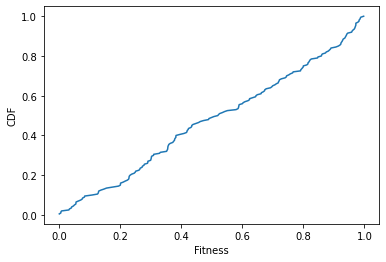

In [208]:
agents = [Replicator() for _ in range(200)]
population = Population(agents, avg_lifespan=40)  # 200/40 --> 5 deaths/births per step
population.step()
assert len(population.population) == len(agents) and any(agent not in agents for agent in population.population)
dead = population.choose_dead()
replacements = population.choose_replacements(len(dead))
assert len(dead) == len(replacements)
print(f"Agents at {list(dead)} are replaced by {len(replacements)} replacements")
population.plot()

## Instruments
Each Instrument tracks a population metric over the course of a simulation, i.e., a time series
For starters, we will track the mean "trait" value.

In [209]:
class Instrument:
    """ An Instrument computes and stores a metric timeseries for a model and knows how to plot it. """
    label = ''

    def __init__(self):
        """ A instrument that tracks one metric for given model over a timeseries """
        self.metric_values = []

    def update(self, model):
        """ Compute the metric from current state of the model (i.e., next value in timeseries) """
        raise NotImplementedError  # concrete Instruments must implement this.

    def plot(self, ax, **options):
        """ Plot the timeseries for this metric on the given subplot axis """
        ax.set_ylabel(self.label)
        ax.set_xlabel('Time')
        ax.plot(self.metric_values, **options)


class MeanTraitInstrument(Instrument):
    """ Track mean trait across population of Replicators in Population model at each timestep. """
    label = 'Mean trait'

    def update(self, model):
        mean_trait = np.nanmean([agent.trait for agent in model.population])
        self.metric_values.append(mean_trait)

## A Natural Selection Experiment:
This generic experiment runs a series of simulations, each with the same sized population and number of time steps.
The Replicator, Fitness, and Instrument models are "injected" so this function can be re-used for different experiments.

In [210]:
def get_axes(n_plots):
    """ return a list of n pyplot axes """
    _, axes = plt.subplots(1, n_plots, figsize=(n_plots*6, 4))
    return axes if n_plots > 1 else [axes]

def experiment(n_runs=10, n_agents=200, n_steps=100,
               ReplicatorModel=Replicator, PopulationModel=Population, InstrumentModels=(MeanTraitInstrument,)):
    """ Run a series of simulations, each with n_agents for n_steps, using given Replicator, Population, and Instrument models """
    axes = get_axes(n_plots=len(InstrumentModels))
    axes[0].set_title(f'{n_runs} simulation runs with {PopulationModel.__name__}')

    for _ in range(n_runs):
        agents = [ReplicatorModel() for _ in range(n_agents)]
        sim = Simulation(PopulationModel(agents), *(Instrument() for Instrument in InstrumentModels))
        sim.run(n_steps)
        sim.plot_instruments(axes=axes)
    plt.show()

### Experiment: No Differentiation == random walk through "fitness landscape"
What happens when we simulate the "flat" fitness landscape, with no differentiation among Replicator agents.

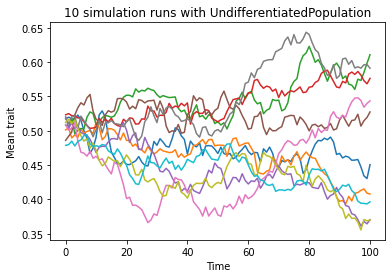

In [211]:
experiment(PopulationModel=UndifferentiatedPopulation)

## Differentiation
Agents are differentiated by survival and/or reproductive success, based on their "trait(s)"

### Experiment: Fitness for Reproductive Success
Agents whose "trait(s)" confirm a higher reproductive success will reproduce more.  Duh.


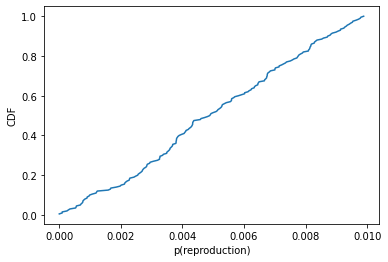

In [212]:
class DifferentialReproduction(Population):
    """ Differentiate agents on reproduction - probability of reproducing is proportional to "trait" value """

    def p_reproduction(self):
        """ Returns array with relative probability (sum to 1), between 0 - 1, each agent reproduces in this timestep """
        return self.traits / np.sum(self.traits)

agents = [Replicator() for _ in range(200)]
population = DifferentialReproduction(agents)
population.plot(metric='p(reproduction)')

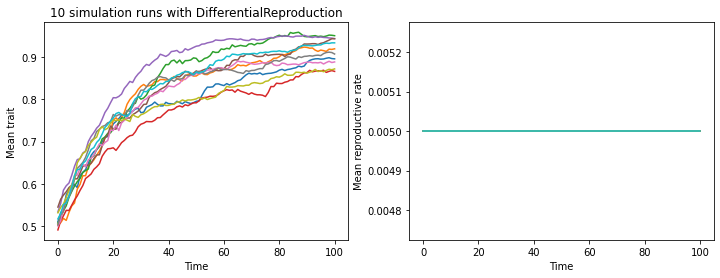

In [213]:
class MeanReproductiveRateInstrument(Instrument):
    """ Track mean death rate across population of Replicators in Fitness model at each timestep. """
    label = 'Mean reproductive rate'

    def update(self, model):
        mean_rate = np.nanmean(model.p_reproduction())
        self.metric_values.append(mean_rate)

experiment(PopulationModel=DifferentialReproduction, InstrumentModels=(MeanTraitInstrument, MeanReproductiveRateInstrument,))

### Experiment: Fitness for Survival
Agents whose "trait(s)" confirm a higher survival probability will tend to survive and pass on their traits.  Duh.

Achieved Mean death rate:  0.1 (target: 0.1)


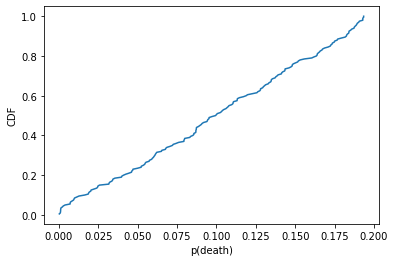

In [214]:
class DifferentialSurvival(Population):
    """ Differentiate agents on survival - probability of survival is proportional to "trait" value """
    def p_death(self):
        """ Returns array with absolute probability, between 0 - 1, each agent dies in this timestep """
        traits = 1-self.traits  # survival proportional to trait value --> prob. of death proportional to (1-trait)
        scale = self.avg_death_rate * self.n  # scale traits so avg_death_rate is maintained over population of size n
        return scale * traits / np.sum(traits)

agents = [Replicator() for _ in range(200)]
population = DifferentialSurvival(agents)
print("Achieved Mean death rate: ", np.mean(population.p_death()), f'(target: {population.avg_death_rate})')
assert np.abs(np.mean(population.p_death()) - population.avg_death_rate) < 0.001  # average death rate over population should be maintained.
population.plot(metric='p(death)')

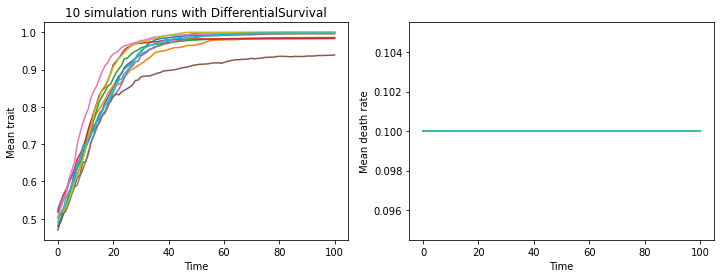

In [215]:
class MeanDeathRateInstrument(Instrument):
    """ Track mean death rate across population of Replicators in Fitness model at each timestep. """
    label = 'Mean death rate'

    def update(self, model):
        mean_rate = np.nanmean(model.p_death())
        self.metric_values.append(mean_rate)

experiment(PopulationModel=DifferentialSurvival, InstrumentModels=(MeanTraitInstrument, MeanDeathRateInstrument,))